In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from surface_code import create_surface_code_circuit, run_with_errors, plot_ler_vs_p_from_stats
from surface_code import build_spacetime_decoders, decode_counts_spacetime, checks_to_H

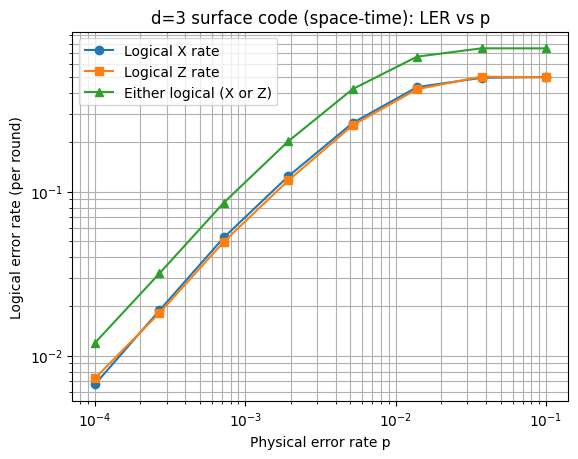

In [10]:
# === Space-time LER vs p sweep & plot ===
# Assumes the functions listed above are already defined in prior cells.

import numpy as np

distance = 3
SHOTS_PER_P = 20000
SEED = 12345
# Physical error sweep (tweak as you like)
PS = np.logspace(-4, -1, 8)  # 1e-4 ... 1e-1

# Logical strings (match your boundary choice from create_surface_code_circuit)
X_L_support = [1, 4, 7]   # vertical (connects X-boundaries) → used with z-type residual
Z_L_support = [3, 4, 5]   # horizontal (connects Z-boundaries) → used with x-type residual

qc, X_checks, Z_checks, n_data, n_rounds = create_surface_code_circuit(distance=distance)
assert n_rounds >= 2, "Space-time decoding needs at least 2 rounds."

dec_Xst, dec_Zst, meta = build_spacetime_decoders(X_checks, Z_checks, n_data, n_rounds)

H_X = checks_to_H(X_checks, n_data)
H_Z = checks_to_H(Z_checks, n_data)

stats_by_p = {}
for p in PS:
    counts = run_with_errors(
        qc,
        p1=p,          # 1q depolarizing rate
        p2=p,          # 2q depolarizing rate (you can try p2=2*p if desired)
        p_meas=p,      # readout flips
        p_reset=p/2,   # reset error
        shots=SHOTS_PER_P,
        seed=SEED,
    )

    # stats = decode_counts_spacetime(
    #     counts=counts,
    #     dec_Xst=dec_Xst, dec_Zst=dec_Zst,
    #     X_checks=X_checks, Z_checks=Z_checks,
    #     n_data=n_data, n_rounds=n_rounds,
    #     X_L_support=X_L_support, Z_L_support=Z_L_support
    # )

    stats = decode_counts_spacetime(
        counts, dec_Xst, dec_Zst,
        X_checks, Z_checks, n_data, n_rounds,
        X_L_support=X_L_support, Z_L_support=Z_L_support,
        H_X=H_X, H_Z=H_Z
    )
    stats_by_p[float(p)] = stats

fig, ax, df = plot_ler_vs_p_from_stats(stats_by_p, title=f"d={distance} surface code (space-time): LER vs p")